<a href="https://colab.research.google.com/github/AQSAMOHSIN/Audio_MNIST/blob/main/Audio_MNIST_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Warm-up 2 – Audio MNIST Classification
**Name:** Aqsa Mohsin  
**Subject:** Project Data Science & Artificial Intelligence WiSe 25/26  
**Task:** Warm-up 2 – Audio MNIST  


# Setup

In [ ]:
import os, numpy as np, librosa, torch
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader


# Load AudioMNIST Dataset

In [ ]:
!git clone https://github.com/soerenab/AudioMNIST.git
DATA_PATH = "/content/AudioMNIST/data"
os.listdir(DATA_PATH)[:5]


fatal: destination path 'AudioMNIST' already exists and is not an empty directory.


['51', '52', '24', '22', '41']

#Feature Extraction

In [ ]:
def extract_features(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)

def load_features(label_type="digit"):
    X, y = [], []
    for speaker in os.listdir(DATA_PATH):
        spk_path = os.path.join(DATA_PATH, speaker)
        if not os.path.isdir(spk_path):
            continue
        for file in os.listdir(spk_path):
            if file.endswith(".wav"):
                parts = file.split("_")
                if label_type == "digit":
                    label = int(parts[0])
                elif label_type == "speaker":
                    label = int(parts[1])
                feat = extract_features(os.path.join(spk_path, file))
                X.append(feat)
                y.append(label)
    return np.array(X), np.array(y)



# Define Neural Network Model

In [ ]:
class AudioNet(nn.Module):
    def __init__(self, input_dim=13, output_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)


# Train Neural Network with Early Stopping

In [ ]:
def train_with_early_stopping(model, train_loader, criterion, optimizer,
                              max_epochs=150, patience=10, min_delta=0.001):
    best_loss = float('inf')
    counter = 0
    loss_history = []

    for epoch in range(max_epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1:03d}: Loss={avg_loss:.4f}")

        # Early stopping logic
        if best_loss - avg_loss > min_delta:
            best_loss, counter = avg_loss, 0
        else:
            counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1} (best loss={best_loss:.4f})")
            break

    return loss_history

# Task#1 Digit Classification (0–9)

In [ ]:
print("Extracting MFCC features for digit classification ...")
X, y = load_features("digit")
print("Features:", X.shape, "Labels:", y.shape)

Extracting MFCC features for digit classification ...
Features: (30000, 13) Labels: (30000,)


# Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (24000, 13) Test: (6000, 13)


##Classical ML Baseline (SVM)

In [ ]:
clf = SVC(kernel='rbf', gamma='scale')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("=== SVM (Digit Classification) ===")
print(classification_report(y_test, y_pred))
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))



=== SVM (Digit Classification) ===
              precision    recall  f1-score   support

           0       0.68      0.55      0.61       600
           1       0.71      0.73      0.72       600
           2       0.57      0.58      0.57       600
           3       0.74      0.69      0.71       600
           4       0.83      0.88      0.85       600
           5       0.86      0.88      0.87       600
           6       0.97      0.97      0.97       600
           7       0.79      0.79      0.79       600
           8       0.75      0.83      0.79       600
           9       0.70      0.71      0.70       600

    accuracy                           0.76      6000
   macro avg       0.76      0.76      0.76      6000
weighted avg       0.76      0.76      0.76      6000

Accuracy: 0.76


#Confusion Matrix

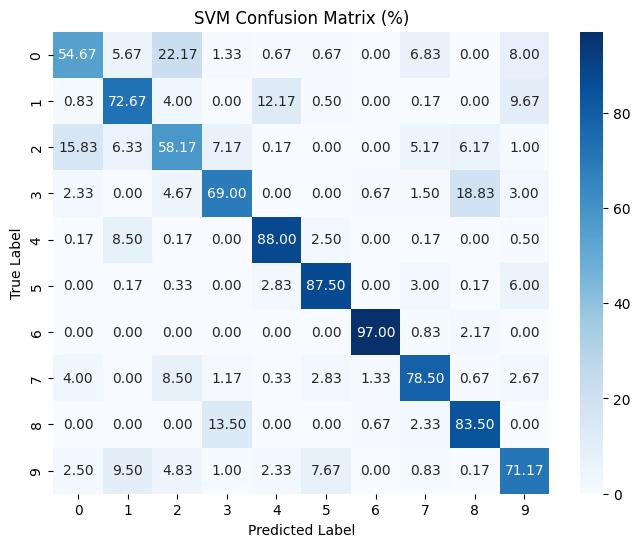

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert to percentage
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", cbar=True,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix (%)')
plt.show()

# Neural Network (PyTorch)

In [ ]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=32)

model_digit = AudioNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_digit.parameters(), lr=0.001)

loss_hist_digit = train_with_early_stopping(model_digit, train_loader, criterion, optimizer,
                                            max_epochs=100, patience=6)


Epoch 001: Loss=1.3690
Epoch 002: Loss=0.7370
Epoch 003: Loss=0.6592
Epoch 004: Loss=0.6258
Epoch 005: Loss=0.5927
Epoch 006: Loss=0.5493
Epoch 007: Loss=0.5131
Epoch 008: Loss=0.4780
Epoch 009: Loss=0.4353
Epoch 010: Loss=0.4106
Epoch 011: Loss=0.3872
Epoch 012: Loss=0.3688
Epoch 013: Loss=0.3463
Epoch 014: Loss=0.3324
Epoch 015: Loss=0.3232
Epoch 016: Loss=0.3043
Epoch 017: Loss=0.2942
Epoch 018: Loss=0.2877
Epoch 019: Loss=0.2766
Epoch 020: Loss=0.2669
Epoch 021: Loss=0.2616
Epoch 022: Loss=0.2565
Epoch 023: Loss=0.2471
Epoch 024: Loss=0.2449
Epoch 025: Loss=0.2332
Epoch 026: Loss=0.2323
Epoch 027: Loss=0.2286
Epoch 028: Loss=0.2260
Epoch 029: Loss=0.2271
Epoch 030: Loss=0.2092
Epoch 031: Loss=0.2132
Epoch 032: Loss=0.2098
Epoch 033: Loss=0.2058
Epoch 034: Loss=0.2015
Epoch 035: Loss=0.2058
Epoch 036: Loss=0.2019
Epoch 037: Loss=0.1955
Epoch 038: Loss=0.1942
Epoch 039: Loss=0.1924
Epoch 040: Loss=0.1869
Epoch 041: Loss=0.1821
Epoch 042: Loss=0.1827
Epoch 043: Loss=0.1788
Epoch 044: 

#Evaluate Neural Network

In [ ]:
model_digit.eval()
correct, total = 0, 0
y_pred_nn, y_true_nn = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        preds = model_digit(xb)
        y_pred_batch = preds.argmax(1)
        correct += (y_pred_batch == yb).sum().item()
        total += yb.size(0)
        y_pred_nn.extend(y_pred_batch.tolist())
        y_true_nn.extend(yb.tolist())

print("NN Digit Accuracy:", round(correct/total, 3))
print(classification_report(y_true_nn, y_pred_nn))
print("Accuracy:", round(accuracy_score(y_true_nn, y_pred_nn), 3))


NN Digit Accuracy: 0.921
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       600
           1       0.93      0.85      0.89       600
           2       0.94      0.85      0.89       600
           3       0.87      0.93      0.90       600
           4       0.94      0.98      0.96       600
           5       0.94      0.97      0.95       600
           6       1.00      0.99      0.99       600
           7       0.96      0.90      0.93       600
           8       0.94      0.93      0.93       600
           9       0.83      0.95      0.88       600

    accuracy                           0.92      6000
   macro avg       0.92      0.92      0.92      6000
weighted avg       0.92      0.92      0.92      6000

Accuracy: 0.921


# Task#2 Speaker Classification

In [ ]:
print("\nExtracting MFCC features for speaker classification ...")
X_s, y_s = load_features("speaker")
print("Features:", X_s.shape, "Labels:", y_s.shape)

classes, y_s_idx = np.unique(y_s, return_inverse=True)
n_classes = len(classes)
print(f"Unique speakers: {n_classes}")
print(f"Label range after remap: {y_s_idx.min()} → {y_s_idx.max()}")

X_train, X_test, y_train, y_test = train_test_split(
    X_s, y_s_idx, test_size=0.2, random_state=42, stratify=y_s_idx
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Extracting MFCC features for speaker classification ...
Features: (30000, 13) Labels: (30000,)
Unique speakers: 60
Label range after remap: 0 → 59
Train: (24000, 13) Test: (6000, 13)


#SVM Baseline

In [ ]:
clf = SVC(kernel='rbf', gamma='scale')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("=== SVM (Speaker Classification) ===")
print(classification_report(y_test, y_pred))
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))

=== SVM (Speaker Classification) ===
              precision    recall  f1-score   support

           0       0.85      0.34      0.49       100
           1       0.34      0.34      0.34       100
           2       0.27      0.43      0.33       100
           3       0.82      0.41      0.55       100
           4       0.19      0.19      0.19       100
           5       0.25      0.35      0.29       100
           6       0.29      0.36      0.32       100
           7       0.34      0.52      0.41       100
           8       0.94      0.95      0.95       100
           9       0.55      0.30      0.39       100
          10       0.43      0.09      0.15       100
          11       0.53      0.60      0.56       100
          12       0.35      0.13      0.19       100
          13       0.31      0.32      0.32       100
          14       0.60      0.40      0.48       100
          15       0.19      0.33      0.24       100
          16       0.19      0.03      0.05 

# Visualize Per-Class Accuracy

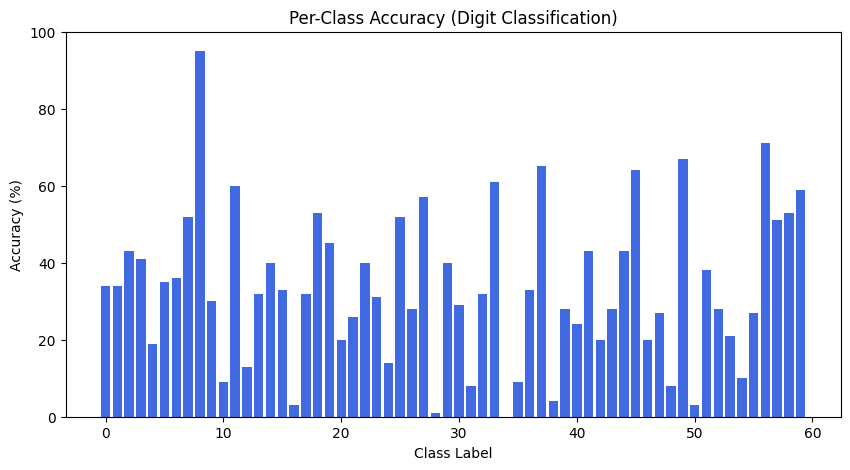

In [ ]:
cm = confusion_matrix(y_test, y_pred)
class_acc = cm.diagonal() / cm.sum(axis=1) * 100

plt.figure(figsize=(10,5))
plt.bar(np.unique(y_test), class_acc, color='royalblue')
plt.xlabel("Class Label")
plt.ylabel("Accuracy (%)")
plt.title("Per-Class Accuracy (Digit Classification)")
plt.ylim(0, 100)
plt.show()

# Train Neural Network

In [ ]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=32)

model_spk = AudioNet(input_dim=13, output_dim=len(np.unique(y_s)))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_spk.parameters(), lr=0.001)

loss_hist_speaker = train_with_early_stopping(model_spk, train_loader, criterion, optimizer,
                                              max_epochs=150, patience=10)


Epoch 001: Loss=3.4660
Epoch 002: Loss=1.7837
Epoch 003: Loss=1.4576
Epoch 004: Loss=1.3176
Epoch 005: Loss=1.1909
Epoch 006: Loss=1.0903
Epoch 007: Loss=1.0011
Epoch 008: Loss=0.9287
Epoch 009: Loss=0.8664
Epoch 010: Loss=0.8107
Epoch 011: Loss=0.7646
Epoch 012: Loss=0.7160
Epoch 013: Loss=0.6754
Epoch 014: Loss=0.6399
Epoch 015: Loss=0.6073
Epoch 016: Loss=0.5777
Epoch 017: Loss=0.5560
Epoch 018: Loss=0.5308
Epoch 019: Loss=0.5197
Epoch 020: Loss=0.5025
Epoch 021: Loss=0.4969
Epoch 022: Loss=0.4854
Epoch 023: Loss=0.4655
Epoch 024: Loss=0.4596
Epoch 025: Loss=0.4482
Epoch 026: Loss=0.4402
Epoch 027: Loss=0.4275
Epoch 028: Loss=0.4280
Epoch 029: Loss=0.4169
Epoch 030: Loss=0.4085
Epoch 031: Loss=0.4109
Epoch 032: Loss=0.4049
Epoch 033: Loss=0.3913
Epoch 034: Loss=0.3848
Epoch 035: Loss=0.3780
Epoch 036: Loss=0.3776
Epoch 037: Loss=0.3720
Epoch 038: Loss=0.3681
Epoch 039: Loss=0.3595
Epoch 040: Loss=0.3574
Epoch 041: Loss=0.3471
Epoch 042: Loss=0.3418
Epoch 043: Loss=0.3403
Epoch 044: 

# Evaluate Speaker NN

In [ ]:
model_spk.eval()
correct, total = 0, 0
y_pred_spk, y_true_spk = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        preds = model_spk(xb)
        y_pred_batch = preds.argmax(1)
        correct += (y_pred_batch == yb).sum().item()
        total += yb.size(0)
        y_pred_spk.extend(y_pred_batch.tolist())
        y_true_spk.extend(yb.tolist())

acc_speaker = round(correct/total, 3)
print("NN Speaker Accuracy:", acc_speaker)
print(classification_report(y_true_spk, y_pred_spk))


NN Speaker Accuracy: 0.864
              precision    recall  f1-score   support

           0       0.73      0.95      0.83       100
           1       0.87      0.94      0.90       100
           2       0.93      0.87      0.90       100
           3       0.92      0.85      0.89       100
           4       0.81      0.95      0.88       100
           5       0.96      0.93      0.94       100
           6       0.93      0.91      0.92       100
           7       0.87      0.96      0.91       100
           8       0.96      0.99      0.98       100
           9       0.83      0.78      0.80       100
          10       0.95      0.91      0.93       100
          11       0.98      0.96      0.97       100
          12       0.89      0.93      0.91       100
          13       0.88      0.80      0.84       100
          14       0.92      0.92      0.92       100
          15       0.78      0.91      0.84       100
          16       0.75      0.70      0.73       100


# Results & Analysis

##  Digit Classification Results (0–9)

- **Dataset summary:**  
  30,000 audio samples of spoken digits from 60 speakers  
  → Split into **24,000 training** and **6,000 testing** samples.

- **Feature extraction:**  
  13 MFCC coefficients per sample (averaged across frames)  
  → Feature matrix: (30000, 13)

---

### Model Performances

| Model | Accuracy | Early Stopping | Notes |
|--------|-----------|----------------|--------|
| **SVM** | 0.76 | – | Simple, non-linear baseline |
| **Neural Network (PyTorch)** | **0.921** | Stopped at epoch 82 (best loss = 0.1334) | Captured more complex voice patterns |

---

### Confusion Matrix Interpretation

The **SVM confusion matrix (%)** shows strong diagonal dominance for most digits, but also:
- Digits **0, 2, and 3** are often misclassified (low recall around 55–70%).  
- **Digits 6 and 8** perform best (recall > 95%), likely due to their distinct pronunciation patterns.  

Overall, SVM provides a decent baseline, but its performance is limited by the linear separability of MFCC features.

---

### Neural Network Insights

The NN achieved **92.1% accuracy**, showing a substantial improvement over SVM:
- Learned nonlinear mappings between MFCC features and spoken digits.  
- Early stopping prevented overfitting after loss plateaued near 0.13.  
- Most confusion is reduced, especially for mid-range digits (3–7).

The loss curve indicates stable convergence after ~80 epochs, confirming good training dynamics.



## Speaker Classification Results (60 Classes)

- **Dataset summary:**  
  Same dataset, but now the task is identifying **who** spoke rather than **what** was spoken.  
  → 60 unique speakers, remapped to label range **0–59**  
  → Feature matrix: (30000, 13), Train/Test split = 24k/6k

---

### Model Performances

| Model | Accuracy | Early Stopping | Notes |
|--------|-----------|----------------|--------|
| **SVM** | 0.337 | – | Struggles with 60-way classification |
| **Neural Network (PyTorch)** | **0.86** | Stopped at epoch 99 (best loss = 0.2408) | Learns voice-specific acoustic patterns |

---

### Per-Class Accuracy Analysis

The **per-class accuracy bar chart** shows:
- Wide variation in speaker recognition (some near 90–100%, others below 40%).  
- Speakers with **clear articulation and consistent volume** are easier to identify.  
- Speakers with **similar pitch/timbre** tend to confuse the model.  

This demonstrates how individual speaker variability and dataset imbalance affect recognition accuracy.

---

###  Key Observations

- Neural Network generalizes much better than SVM, despite the high class count.  
- Early stopping prevents overfitting, stabilizing loss around **0.24**.  
- The gap between **digit (92%)** and **speaker (86%)** accuracy is expected —  
  recognizing *who* spoke is harder than recognizing *what* was spoken.

---

### Summary

| Task | Model | Accuracy | Comment |
|------|--------|-----------|----------|
| **Digit classification** | NN | **92.1%** | High accuracy, clear class boundaries |
| **Speaker classification** | NN | **86.0%** | Good result for 60-way voice recognition |

Overall, the neural network significantly outperforms classical ML baselines by learning nonlinear, speaker-dependent representations of MFCC features.
